<a href="https://colab.research.google.com/github/KuperOK/DataFrame_libs_comparison/blob/main/Pandas_vs_Polars_vs_Dask_vs_cuDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Comparison of `dataframe` libraries

**Pandas:** A powerful and flexible Python library for data manipulation and analysis. Provides data structures like DataFrames for efficient data handling. Primarily CPU-bound.

**Polars:** A blazingly fast DataFrame library written in Rust. Designed for performance and efficient memory usage. Leverages parallelism and optimized query execution.

**Dask:** A flexible parallel computing library for Python. Enables parallel execution on larger-than-memory datasets. Can be used with Pandas DataFrames by partitioning them.

**cuDF:** A GPU DataFrame library built on Apache Arrow. Leverages the power of NVIDIA GPUs for accelerated data manipulation and analysis.

In [1]:
# Before turn on GPU accelerator
!nvidia-smi

Mon Mar 10 11:38:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import cupy as cp

print("CUDA devices available:", cp.cuda.runtime.getDeviceCount())
device = cp.cuda.Device(0)
print("GPU Compute Capability:", device.compute_capability)

CUDA devices available: 1
GPU Compute Capability: 75


In [2]:
import time
import numpy as np
import pandas as pd
import polars as pl
import dask.dataframe as dd
import cudf
import cupy as cp

In [3]:
n_rows = 10**7
n_cols = 5

# Create random data
data_np = np.random.rand(n_rows, n_cols)
columns = [f'col_{i}' for i in range(n_cols)]

In [6]:
# ----------------- Pandas -----------------
df_pd = pd.DataFrame(data_np, columns=columns)

start_time = time.time()
df_pd_sum = df_pd.sum()
pandas_sum_time = time.time() - start_time

start_time = time.time()
df_pd_filtered = df_pd[df_pd["col_0"] > 0.5]
pandas_filter_time = time.time() - start_time

start_time = time.time()
df_pd["category"] = np.random.choice(["A", "B", "C", "D"], size=n_rows)
df_pd_grouped = df_pd.groupby("category").mean()
pandas_groupby_time = time.time() - start_time

start_time = time.time()
df_pd_sorted = df_pd.sort_values("col_1")
pandas_sort_time = time.time() - start_time

print(f'Pandas: SUM {pandas_sum_time:.3f}s | FILTER {pandas_filter_time:.3f}s | GROUPBY {pandas_groupby_time:.3f}s | SORT {pandas_sort_time:.3f}s')

Pandas: SUM 0.619s | FILTER 0.209s | GROUPBY 0.967s | SORT 3.335s


In [7]:
# ----------------- Polars -----------------
df_pl = pl.DataFrame(data_np, schema=columns)

start_time = time.time()
df_pl_sum = df_pl.sum()
polars_sum_time = time.time() - start_time

start_time = time.time()
df_pl_filtered = df_pl.filter(pl.col("col_0") > 0.5)
polars_filter_time = time.time() - start_time

start_time = time.time()
df_pl = df_pl.with_columns(pl.Series("category", np.random.choice(["A", "B", "C", "D"], size=n_rows)))
df_pl_grouped = df_pl.group_by("category").agg(pl.all().mean())
polars_groupby_time = time.time() - start_time

start_time = time.time()
df_pl_sorted = df_pl.sort("col_1")
polars_sort_time = time.time() - start_time

print(f'Polars: SUM {polars_sum_time:.3f}s | FILTER {polars_filter_time:.3f}s | GROUPBY {polars_groupby_time:.3f}s | SORT {polars_sort_time:.3f}s')

Polars: SUM 0.029s | FILTER 0.115s | GROUPBY 2.899s | SORT 2.686s


In [20]:
# ----------------- Dask -----------------
# df_dask = dd.from_array(data_np, columns=columns, npartitions=10)
df_dask = dd.from_pandas(pd.DataFrame(data_np, columns=columns), npartitions=10)


start_time = time.time()
# df_dask_sum = df_dask.sum().compute()
df_dask.select_dtypes(include=["number"]).sum().compute()
dask_sum_time = time.time() - start_time

start_time = time.time()
df_dask_filtered = df_dask[df_dask["col_0"] > 0.5].compute()
dask_filter_time = time.time() - start_time

start_time = time.time()
df_dask["category"] = dd.from_array(np.random.choice(["A", "B", "C", "D"], size=n_rows))
df_dask_grouped = df_dask.groupby("category").mean().compute()
dask_groupby_time = time.time() - start_time

start_time = time.time()
df_dask_sorted = df_dask.sort_values("col_1").compute()
dask_sort_time = time.time() - start_time

print(f'Dask splited: SUM {dask_sum_time:.2f}s | FILTER {dask_filter_time:.2f}s | GROUPBY {dask_groupby_time:.2f}s | SORT {dask_sort_time:.2f}s')

Dask splited: SUM 0.11s | FILTER 0.21s | GROUPBY 3.59s | SORT 5.46s


In [17]:
df_dask_2 = dd.from_array(data_np, columns=columns)

start_time = time.time()
df_dask.select_dtypes(include=["number"]).sum().compute()
dask_sum_time2 = time.time() - start_time

start_time = time.time()
df_dask_filtered = df_dask[df_dask["col_0"] > 0.5].compute()
dask_filter_time2 = time.time() - start_time

start_time = time.time()
df_dask["category"] = dd.from_array(np.random.choice(["A", "B", "C", "D"], size=n_rows))
df_dask_grouped = df_dask.groupby("category").mean().compute()
dask_groupby_time2 = time.time() - start_time

start_time = time.time()
df_dask_sorted = df_dask.sort_values("col_1").compute()
dask_sort_time2 = time.time() - start_time

print(f'Dask NOT splited: SUM {dask_sum_time2:.3f}s | FILTER {dask_filter_time2:.3f}s | GROUPBY {dask_groupby_time2:.3f}s | SORT {dask_sort_time2:.3f}s')

Dask NOT splited: SUM 1.510s | FILTER 1.474s | GROUPBY 2.904s | SORT 5.418s


In [10]:
# ----------------- RAPIDS (cuDF) -----------------
data_cp = cp.asarray(data_np)
df_cudf = cudf.DataFrame(data_cp.get(), columns=columns)

start_time = time.time()
df_cudf_sum = df_cudf.sum()
rapids_sum_time = time.time() - start_time

start_time = time.time()
df_cudf_filtered = df_cudf[df_cudf["col_0"] > 0.5]
rapids_filter_time = time.time() - start_time

start_time = time.time()
df_cudf["category"] = np.random.choice(["A", "B", "C", "D"], size=n_rows)
df_cudf_grouped = df_cudf.groupby("category").mean()
rapids_groupby_time = time.time() - start_time

start_time = time.time()
df_cudf_sorted = df_cudf.sort_values("col_1")
rapids_sort_time = time.time() - start_time

print(f'RAPIDS cuDF: SUM {rapids_sum_time:.3f}s | FILTER {rapids_filter_time:.3f}s | GROUPBY {rapids_groupby_time:.3f}s | SORT {rapids_sort_time:.3f}s')

RAPIDS cuDF: SUM 0.113s | FILTER 0.094s | GROUPBY 1.030s | SORT 0.233s


In [18]:
results = pd.DataFrame({
    'Pandas': [pandas_sum_time, pandas_filter_time, pandas_groupby_time, pandas_sort_time],
    'Polars': [polars_sum_time, polars_filter_time, polars_groupby_time, polars_sort_time],
    'Dask_with_parts': [dask_sum_time, dask_filter_time, dask_groupby_time, dask_sort_time],
    'Dask_without_parts': [dask_sum_time2, dask_filter_time2, dask_groupby_time2, dask_sort_time2],
    'cuDF': [rapids_sum_time, rapids_filter_time, rapids_groupby_time, rapids_sort_time]
}, index=["SUM", "FILTER", "GROUPBY", "SORT"])


print(results)

           Pandas    Polars  Dask_with_parts  Dask_without_parts      cuDF
SUM      0.619053  0.029147         0.141767            1.510277  0.112732
FILTER   0.209184  0.114756         0.728079            1.473987  0.093828
GROUPBY  0.966744  2.899146         3.631804            2.903593  1.030282
SORT     3.335306  2.686436         5.402755            5.418456  0.232546


<Axes: >

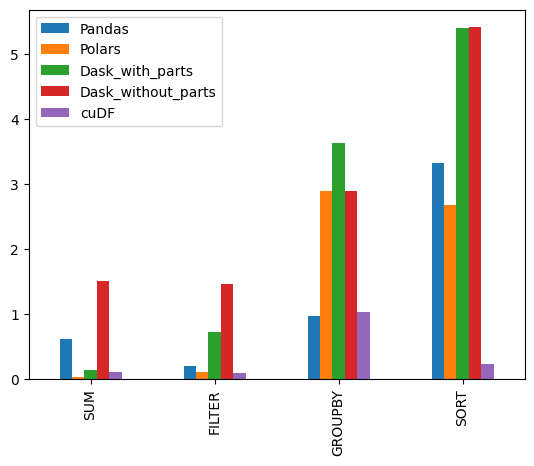

In [19]:
results.plot(kind='bar')

### Overall Observations:

- **Polars** generally performs the best across most operations, showing very fast execution times for `SUM`, `FILTER`, and `SORT`, but it struggles with `GROUPBY`, where **cuDF** excels.
- **Dask** performs well when partitioning is used for operations like `SUM` and `FILTER`, but its performance for `GROUPBY` and `SORT` suffers, especially without partitioning.
- **cuDF** shows exceptional performance, especially for operations that benefit from GPU acceleration (`SUM`, `FILTER`, and `SORT`). However, its `GROUPBY` performance, while good, is slower than that of **Polars** and **Pandas**.
- **Pandas** remains a solid choice for operations like `GROUPBY` and works well for smaller datasets, but it lags behind in operations like `SUM` and `SORT` when compared to other optimized libraries.

### Conclusion:
- **Polars** is a great option for most operations if you're dealing with large datasets and need fast execution.
- **cuDF** provides the best performance for `SUM`, `FILTER`, and `SORT` if you have access to GPU resources.
- **Dask** shines for distributed computing, especially when partitioning is used, but struggles with certain operations.
- **Pandas**, though slower for many large dataset operations, is still a solid and dependable choice for smaller datasets or when GPU acceleration is not available.